In [ ]:
 """
Done by:
Shankhin Brahmavar (260921778)

AND

Jerry Nyoike (261091227)

"""

# **Install and import necessary libraries**

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.special import softmax

In [ ]:
lake = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# **Define Agents and helper functions**

In [ ]:
# softmax exploration function
def boltzmann_action(Q, s, temp):
  """
  Q: Q Table
  temp: temperature parameter
  s: state
  """
  Q = Q[s, :]
  probs = softmax(Q/temp)
  # probs = np.exp(Q/temp)
  # probs = np.asarray(probs).astype('float64')
  # probs = probs/np.sum(probs)
  return np.argmax(np.random.multinomial(1, probs)) #gets index of action from multinomial distribution of probabilities

In [ ]:
# gets probability of each action given a state (used only for expected SARSA update)
def get_probs(Q, s, temp):
  """
  Q: Q Table
  s: state
  """
  Q = Q[s, :]
  probs = softmax(Q/temp)
  # probs = np.exp(Q/temp)
  # probs = probs/np.sum(probs)
  return probs

In [ ]:
# main expected SARSA agent function
def expected_sarsa_agent(env, alpha, gamma, temp, n_episodes, Q = None):
  """
  env: frozen lake environment
  alpha: learning rate
  gamma: exploration parameter
  temp: temperature parameter
  n_episodes: number of episodes
  """
  # initialize Q table
  if Q is None:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
  t = range(n_episodes)
  # to record reward for each episode
  reward_array = np.zeros(n_episodes)
  for i in t:
        # initial state
        s, _ = env.reset()
        # initial action
        a = boltzmann_action(Q, s, temp)
        done = False
        while not done:
              # get new state and action
              s_, reward, done, _, _ = env.step(a)
              a_ = boltzmann_action(Q, s_, temp)
              # update Q table
              probs = get_probs(Q, s_, temp)
              Q[s, a] += alpha * (reward + (gamma * (np.sum(probs*Q[s_, a]))) - Q[s, a])
              # check if done
              if done:
                    reward_array[i] = reward
                    break
              s, a = s_, a_
  # average reward for all episodes
  avg_reward = round(np.mean(reward_array), 6)
  return avg_reward, Q


In [ ]:
def sarsa_agent(env, alpha, gamma, temp, n_episodes, Q = None): 
  """
  env: frozen lake environment
  alpha: learning rate
  gamma: exploration parameter
  temp: temperature parameter
  n_episodes: number of episodes
  Q : Q table
  """
  # initialize Q table
  if Q is None:
    Q = np.zeros((env.observation_space.n, env.action_space.n))
  t = range(n_episodes)
  # to record reward for each episode
  reward_array = np.zeros(n_episodes)
  for i in t:
        # initial state
        s, _ = env.reset()
        # initial action
        a = boltzmann_action(Q, s, temp)
        done = False
        while not done:
              # get new state and action
              s_, reward, done, _, _ = env.step(a)
              a_ = boltzmann_action(Q, s_, temp)
              # update Q table
              Q[s, a] += alpha * (reward + (gamma * Q[s_, a_]) - Q[s, a])
              # check if done
              if done:
                    reward_array[i] = reward
                    break
              s, a = s_, a_
  # average reward for all episodes
  avg_reward = round(np.mean(reward_array), 6)
  return avg_reward, Q

In [ ]:
# define random argmax function to choose random action incase of actions with equal probability
def random_argmax(values):
  return np.random.choice(np.where(values == values.max())[0])

In [ ]:
# evaluate function (chooses best action/no updates)
def evaluate(env, Q):
  """
  env: frozen lake environment
  Q: trained Q table
  """
  s, _ = env.reset()
  # initial action
  a = random_argmax(Q[s])
  done = False
  while not done:
        s_, reward, done, _, _ = env.step(a)
        # pick a greedy action according the state and trained Q table
        a_ = random_argmax(Q[s_])
        #check if done
        if done:
              break
        s, a = s_, a_
  return reward

# **Functions to run each agent**
Each segment = 10 episodes of training + 1 episode of testing
  
Each run = 500 segments


Only resetting Q values at the end of each run

In [ ]:
def run_sarsa(env, alpha, gamma, temp, train_episodes = 10, segments = 500):
  train_reward_array = np.zeros(segments)
  test_reward_array = np.zeros(segments)
  for i in range(segments):
    if i == 0:
      train_reward, Q = sarsa_agent(env, alpha, gamma, temp, train_episodes) #training
    else:
      train_reward, Q = sarsa_agent(env, alpha, gamma, temp, train_episodes, Q)
    test_reward = evaluate(env, Q) #test
    train_reward_array[i] = train_reward
    test_reward_array[i] = test_reward
  return train_reward_array, test_reward_array

In [ ]:
def run_expected_sarsa(env, alpha, gamma, temp, train_episodes = 10, segments = 500):
  train_reward_array = np.zeros(segments)
  test_reward_array = np.zeros(segments)
  for i in range(segments):
    if i == 0:
      train_reward, Q = expected_sarsa_agent(env, alpha, gamma, temp, train_episodes) #training
    else:
      train_reward, Q = expected_sarsa_agent(env, alpha, gamma, temp, train_episodes, Q)
    test_reward = evaluate(env, Q) #test
    train_reward_array[i] = train_reward
    test_reward_array[i] = test_reward
  return train_reward_array, test_reward_array

# **Plotting**

In [ ]:
def plot_sarsa_over_alpha(env, alpha_list = [0.2, 0.5, 0.8], gamma = 0.001, temp = 0.001, n_runs = 10 ):
  avg_train_reward_at_alpha = np.zeros(len(alpha_list))
  avg_test_reward_at_alpha = np.zeros(len(alpha_list))
  for i in range(len(alpha_list)):
    avg_train_reward_over_runs = np.zeros(n_runs)
    avg_test_reward_over_runs = np.zeros(n_runs)
    for j in trange(n_runs):
      run_train_reward_array, run_test_reward_array  = run_sarsa(lake, alpha_list[i], gamma, temp)
      avg_train_reward_over_runs[j] = round(np.mean(run_train_reward_array), 6)
      avg_test_reward_over_runs[j] = round(np.mean(run_test_reward_array), 6)
    avg_train_reward_at_alpha[i] = round(np.mean(avg_train_reward_over_runs), 6)
    avg_test_reward_at_alpha[i] = round(np.mean(avg_test_reward_over_runs), 6)
  #plot train rewards
  plt.title("Train reward for SARSA Agent over changing alpha")
  plt.plot(alpha_list, avg_train_reward_at_alpha)
  plt.ylabel("Average reward --->")
  plt.xlabel("Learning rate(alpha) -->")
  plt.show()
  #plot test rewards
  plt.title("Test reward for SARSA Agent over changing alpha")
  plt.plot(alpha_list, avg_test_reward_at_alpha)
  plt.ylabel("Average reward --->")
  plt.xlabel("Learning rate(alpha) -->")
  plt.show()

In [ ]:
def plot_expected_sarsa_over_alpha(env, alpha_list = [0.2, 0.5, 0.8], gamma = 0.001, temp = 0.001, n_runs = 10 ):
  avg_train_reward_at_alpha = np.zeros(len(alpha_list))
  avg_test_reward_at_alpha = np.zeros(len(alpha_list))
  for i in range(len(alpha_list)):
    avg_train_reward_over_runs = np.zeros(n_runs)
    avg_test_reward_over_runs = np.zeros(n_runs)
    for j in trange(n_runs):
      run_train_reward_array, run_test_reward_array  = run_expected_sarsa(lake, alpha_list[i], gamma, temp)
      avg_train_reward_over_runs[j] = round(np.mean(run_train_reward_array), 6)
      avg_test_reward_over_runs[j] = round(np.mean(run_test_reward_array), 6)
    avg_train_reward_at_alpha[i] = round(np.mean(avg_train_reward_over_runs), 6)
    avg_test_reward_at_alpha[i] = round(np.mean(avg_test_reward_over_runs), 6)
  #plot train rewards
  plt.title("Train reward for Expected SARSA Agent over changing alpha")
  plt.plot(alpha_list, avg_train_reward_at_alpha)
  plt.ylabel("Average reward --->")
  plt.xlabel("Learning rate(alpha) -->")
  plt.show()
  #plot test rewards
  plt.title("Test reward for Expected SARSA Agent over changing alpha")
  plt.plot(alpha_list, avg_test_reward_at_alpha)
  plt.ylabel("Average reward --->")
  plt.xlabel("Learning rate(alpha) -->")
  plt.show()

Rewards of agents over varying parameters

100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


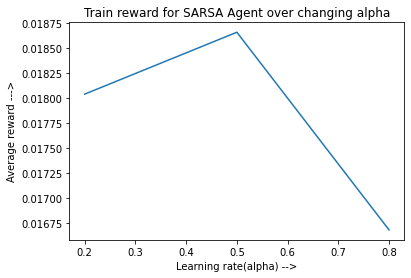

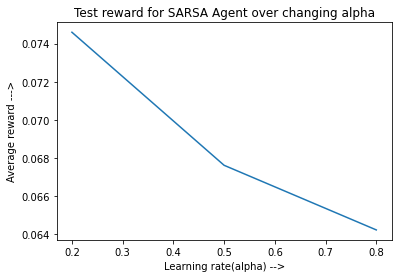

In [ ]:
#Constant gamma and temperature
#Changing alpha
#SARSA run
plot_sarsa_over_alpha(lake)

100%|██████████| 10/10 [00:37<00:00,  3.70s/it]


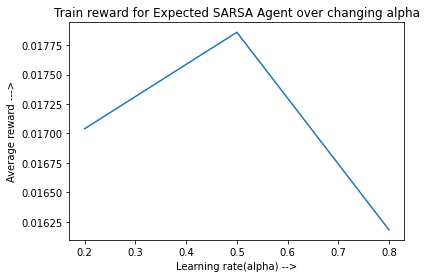

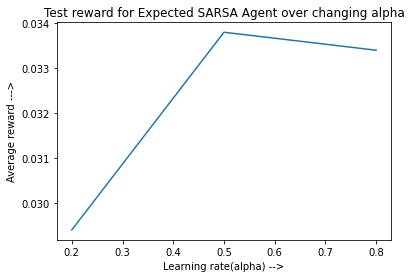

In [ ]:
#Constant gamma and temperature
#Changing alpha
#Expected SARSA run
plot_expected_sarsa_over_alpha(lake)

In [ ]:
def plot_expected_sarsa_over_temp(env, alpha = 0.2, gamma = 0.001, temp_list = [0.001, 0.1, 10], n_runs = 10 ):
  avg_train_reward_at_temp = np.zeros(len(temp_list))
  avg_test_reward_at_temp = np.zeros(len(temp_list))
  for i in range(len(temp_list)):
    avg_train_reward_over_runs = np.zeros(n_runs)
    avg_test_reward_over_runs = np.zeros(n_runs)
    for j in trange(n_runs):
      run_train_reward_array, run_test_reward_array  = run_expected_sarsa(lake, alpha, gamma, temp_list[i])
      avg_train_reward_over_runs[j] = round(np.mean(run_train_reward_array), 6)
      avg_test_reward_over_runs[j] = round(np.mean(run_test_reward_array), 6)
    avg_train_reward_at_temp[i] = round(np.mean(avg_train_reward_over_runs), 6)
    avg_test_reward_at_temp[i] = round(np.mean(avg_test_reward_over_runs), 6)
  #plot train rewards
  plt.title("Train reward for Expected SARSA Agent over changing temperature")
  plt.plot(temp_list, avg_train_reward_at_temp)
  plt.ylabel("Average reward --->")
  plt.xlabel("Temperature -->")
  plt.show()
  #plot test rewards
  plt.title("Test reward for Expected SARSA Agent over changing temperature")
  plt.plot(temp_list, avg_test_reward_at_temp)
  plt.ylabel("Average reward --->")
  plt.xlabel("Temperature -->")
  plt.show()

In [ ]:
def plot_sarsa_over_temp(env, alpha = 0.2, gamma = 0.001, temp_list = [0.001, 0.1, 10], n_runs = 10 ):
  avg_train_reward_at_temp = np.zeros(len(temp_list))
  avg_test_reward_at_temp = np.zeros(len(temp_list))
  for i in range(len(temp_list)):
    avg_train_reward_over_runs = np.zeros(n_runs)
    avg_test_reward_over_runs = np.zeros(n_runs)
    for j in trange(n_runs):
      run_train_reward_array, run_test_reward_array  = run_sarsa(lake, alpha, gamma, temp_list[i])
      avg_train_reward_over_runs[j] = round(np.mean(run_train_reward_array), 6)
      avg_test_reward_over_runs[j] = round(np.mean(run_test_reward_array), 6)
    avg_train_reward_at_temp[i] = round(np.mean(avg_train_reward_over_runs), 6)
    avg_test_reward_at_temp[i] = round(np.mean(avg_test_reward_over_runs), 6)
    #plot train rewards
  plt.title("Train reward for SARSA Agent over changing temperature")
  plt.plot(temp_list, avg_train_reward_at_temp)
  plt.ylabel("Average reward --->")
  plt.xlabel("Temperature -->")
  plt.show()
  #plot test rewards
  plt.title("Test reward for SARSA Agent over changing temperature")
  plt.plot(temp_list, avg_test_reward_at_temp)
  plt.ylabel("Average reward --->")
  plt.xlabel("Temperature -->")
  plt.show()

100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


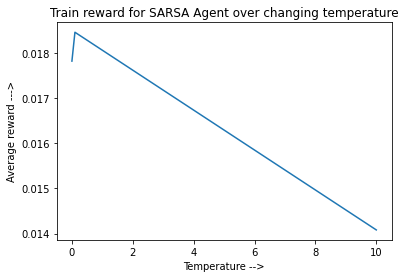

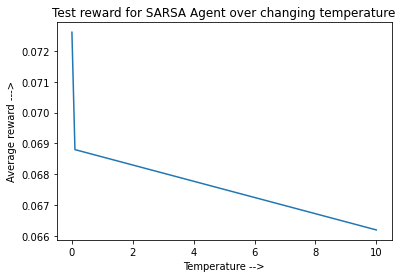

In [ ]:
#Constant gamma and alpha
#Changing temperature
#SARSA run
plot_sarsa_over_temp(lake)

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


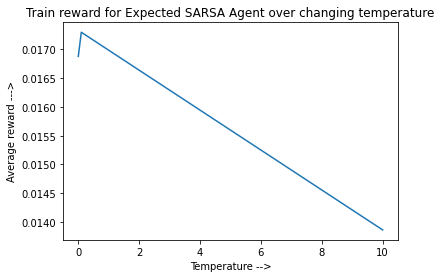

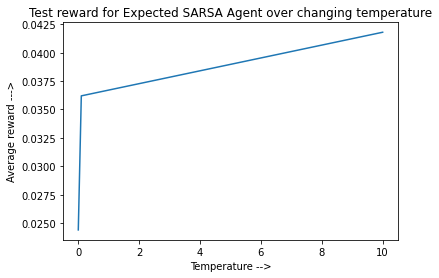

In [ ]:
#Constant gamma and alpha
#Changing temperature
#Expected SARSA run
plot_expected_sarsa_over_temp(lake)

Learning Curve for both agents

In [ ]:
def plot_sarsa_learning_curve(env, alpha = 0.2, gamma = 0.001, temp = 0.1, n_runs = 10):
  avg_train_reward_over_runs = np.zeros(n_runs)
  avg_test_reward_over_runs = np.zeros(n_runs)
  std_train_reward_over_runs = np.zeros(n_runs)
  std_test_reward_over_runs = np.zeros(n_runs)
  x = np.arange(0, n_runs, 1)
  for i in trange(n_runs):
      run_train_reward_array, run_test_reward_array  = run_sarsa(lake, alpha, gamma, temp)
      avg_train_reward_over_runs[i] = round(np.mean(run_train_reward_array), 6)
      avg_test_reward_over_runs[i] = round(np.mean(run_test_reward_array), 6)
      std_train_reward_over_runs = round(np.std(run_train_reward_array), 6)
      std_test_reward_over_runs = round(np.std(run_test_reward_array), 6)
  #plot train rewards
  plt.title("Train reward for SARSA Agent over runs")
  plt.plot(avg_train_reward_over_runs)
  plt.errorbar(x, avg_train_reward_over_runs, std_train_reward_over_runs)
  plt.ylabel("Average reward --->")
  plt.xlabel("Runs -->")
  plt.show()
  #plot test rewards
  plt.title("Test reward for SARSA Agent over runs")
  plt.plot(avg_test_reward_over_runs)
  plt.errorbar(x, avg_test_reward_over_runs, std_test_reward_over_runs)
  plt.ylabel("Average reward --->")
  plt.xlabel("Runs -->")
  plt.show()

100%|██████████| 30/30 [01:15<00:00,  2.50s/it]


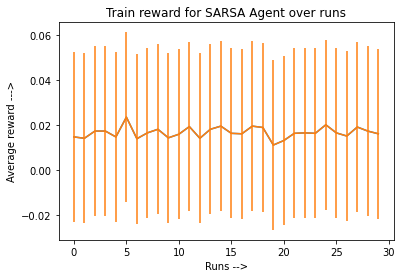

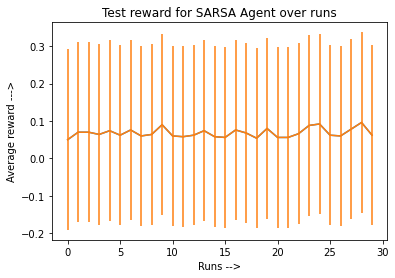

In [ ]:
plot_sarsa_learning_curve(lake, n_runs = 30)

In [ ]:
def plot_expected_sarsa_learning_curve(env, alpha = 0.2, gamma = 0.001, temp = 0.1, n_runs = 10):
  avg_train_reward_over_runs = np.zeros(n_runs)
  avg_test_reward_over_runs = np.zeros(n_runs)
  std_train_reward_over_runs = np.zeros(n_runs)
  std_test_reward_over_runs = np.zeros(n_runs)
  x = np.arange(0, n_runs, 1)
  for i in trange(n_runs):
      run_train_reward_array, run_test_reward_array  = run_expected_sarsa(lake, alpha, gamma, temp)
      avg_train_reward_over_runs[i] = round(np.mean(run_train_reward_array), 6)
      avg_test_reward_over_runs[i] = round(np.mean(run_test_reward_array), 6)
      std_train_reward_over_runs = round(np.std(run_train_reward_array), 6)
      std_test_reward_over_runs = round(np.std(run_test_reward_array), 6)
  #plot train rewards
  plt.title("Train reward for Expected SARSA Agent over runs")
  plt.plot(avg_train_reward_over_runs)
  plt.errorbar(x, avg_train_reward_over_runs, std_train_reward_over_runs)
  plt.ylabel("Average reward --->")
  plt.xlabel("Runs -->")
  plt.show()
  #plot test rewards
  plt.title("Test reward for Expected SARSA Agent over runs")
  plt.plot(avg_test_reward_over_runs)
  plt.errorbar(x, avg_test_reward_over_runs, std_test_reward_over_runs)
  plt.ylabel("Average reward --->")
  plt.xlabel("Runs -->")
  plt.show()

100%|██████████| 30/30 [01:50<00:00,  3.67s/it]


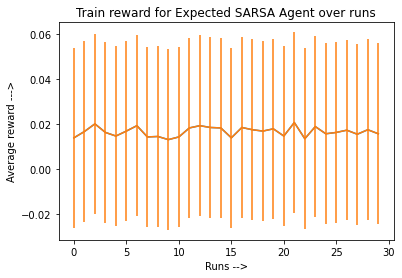

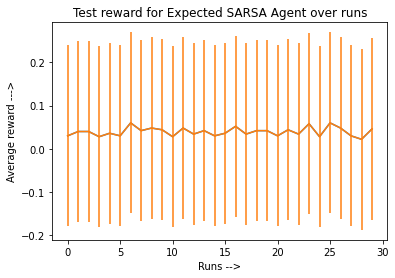

In [ ]:
plot_expected_sarsa_learning_curve(lake, n_runs = 30)

# **Report**

For the experiments to determine the effect of parameters on train and test rewards. For each agent, we train the agent for 10 runs, where the Q table is reset after each run. Each run consists of 500 segments, which consists of 10 training episodes followed by a singular testing episode. 

We see that on average, for both agents, (due to the highly stochastic nature of the problem) an intermediate value of temperature/learning rate yields the best results as we observe a upside down U in these curves. And following these curves, we choose to conclude a temperature value of 0.1 and a learning rate of 0.5 to be the best parameters.

Follwing these experiments, we run both the agents for 30 runs (averaging over the segments and episodes) with these "best" parameters and observe the learning curve. We see that there is a general trend of increasing reward (both train and test). But it is hard to argue that it is indeed learning appropriate Q values due to the highly stochastic nature of the frozen lake.